In [315]:

import urllib.request
import requests
import random
import re
import string
from sklearn.metrics import cohen_kappa_score,silhouette_score

from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture


from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from concurrent.futures import ThreadPoolExecutor
import time

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt

from pprint import pprint

import nltk as nl
from nltk.corpus import stopwords

from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
#  nltk This is one of the most usable and mother of all NLP libraries.
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg #corpus here to define as a semantically oriented dictionary of gutenberg
nl.download('stopwords')
nl.download('wordnet')
nl.download('punkt')
nl.download('omw-1.4')
stop_words=set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rokayaismail/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rokayaismail/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rokayaismail/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rokayaismail/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [316]:
"""# Data Preparing """

books= [["https://www.gutenberg.org/cache/epub/1404/pg1404.txt","Alexander Hamilton"], # Law
           ["https://www.gutenberg.org/cache/epub/3284/pg3284.txt","John Hanning"], # History
           ["https://www.gutenberg.org/cache/epub/1497/pg1497.txt","Plato"],    # Philosophy
           ["https://www.gutenberg.org/cache/epub/1228/pg1228.txt","Charles Darwin"], # Biology
           ["https://www.gutenberg.org/cache/epub/23403/pg23403.txt","Leonard Pearson"]] # Zoology


In [317]:
def get_books_before_filter(books:list) -> list:
    '''
        returns a list of strings, where every string is the book's content.
    '''
    lst_books_txt = []
    for link in books:
        with urllib.request.urlopen(link[0]) as book_file:
            raw = book_file.read().decode('utf-8')
            lst_books_txt.append(raw)
    return lst_books_txt



In [318]:
def get_books(books_links:list) -> list:
  book_list= []
  for book in get_books_before_filter(books_links):
    splited_book = re.split(r"\r\n",book)
    good_paragraphs = [paragraph for paragraph in splited_book if len(paragraph)>=60]
    book_list.append(" ".join(good_paragraphs))
  return book_list

In [319]:
def cleanUp(lstTxt: list) -> list:
    
    '''
        1- CleanUp.
            1.1 include numbers and alphabets only.
            1.2 Change Case to lower case.
            1.3 Remove extra spaces.
            1.4 remove leading whitespaces.
            1.5 Replace punctuation with whitespaces
    '''
    cleaned_lst = []
    for txt in lstTxt:
        txt = re.sub(r'[^A-Z a-z%]', ' ', txt)# include only alphabets and numbers
        txt = re.sub(' +', ' ', txt)# remove extra spaces
        txt = txt.lower()#convert to lower case
        txt = txt.strip()# remove leading whitespaces
        txt = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', txt) #Replace punctuation with whitespaces
        cleaned_lst.append(txt)
    return cleaned_lst

In [320]:
def stopWordRemoval(book_lst: list) -> list:
    l = []
    lemmatizer = WordNetLemmatizer()
    for book in book_lst:
        words = [lemmatizer.lemmatize(token) for token in word_tokenize(book)]
        good_tokens = []
        for word in words:
            if word not in stop_words:
                good_tokens.append(word)
        l.append(" ".join(good_tokens))
    return l

In [321]:
def partitioning(txt:str) -> list:
    
    '''
        This function tries to partition a string into 200 partitions with 100 words for each partition.
        The function expexcts a string and returns a list of strings (where string length is 100) of size 200
        (number of partitions). 
    '''
    
    res = []
    text_as_words = txt.split()
    list_of_partitions = [' '.join(text_as_words[i:i+150]) for i in range(0, len(text_as_words), 150)]
    

    for i in range(200):
    # get random position for a partition
        num = np.random.randint(0,len(list_of_partitions))
        res.append(list_of_partitions[num])
        # remove selected element
        del list_of_partitions[num]
    
    return res



In [322]:
labels=['A', 'B', 'C', 'D', 'E']
def MakeDatafram(lst:list, index:int) -> pd.DataFrame:
    
    '''
        The function consumes a list which is the list of text srings of the book and also an integer which is
        the index of the book in the all list of books and produces a dataframe that maps the lst 
        and the index together into two columns.
        
    '''
    df = pd.DataFrame({'Text': lst,'label':[labels[index]]*200})
    return df

In [323]:
def StackDataFrames(lst:list) -> pd.DataFrame:
    return pd.concat(lst,ignore_index=True)

In [324]:
def prepare(books: list) -> pd.DataFrame:
    '''
        1- select 200 random sample of each book, each record is 100 words.
        2- Label them.
        3- return a DataFrame of all the labeled data.
    '''
    i = 0
    lst_dfs = []
    
    for book in books:
        partition = partitioning(book)
        df = MakeDatafram(partition, i)
        lst_dfs.append(df)
        i += 1
    return StackDataFrames(lst_dfs)

In [325]:
def pre_processing(books: list) -> pd.DataFrame:
    '''
        Aggregate all the preprocessing tasks in one place.
    '''
    cleaned = cleanUp(books)
    without_stop = stopWordRemoval(cleaned)
    
    return prepare(without_stop)

In [326]:
df = pre_processing(get_books(books))

df


,Text,label
0,effectual establishment union best possible pr...,A
1,commit interest delicate momentous kind concer...,A
2,rung upon wealthy well born great inspire disg...,A
3,private justice citizen state supervision agri...,A
4,surrendered prince wa magna charta obtained ba...,A
...,...,...
995,importance diagnosis internal disease wound bo...,E
996,burned buried deeply frequently definition let...,E
997,severity possible operation one simplicity nev...,E
998,rounded elevation size small pea containing bl...,E


In [369]:
# But the real values of pred_clusters_order each time you run this method
def replaceNumbersInArray(arr : np.array,pred_clusters_order,given_clusters_order):
    arr[arr == pred_clusters_order[0]] = 5
    arr[arr == pred_clusters_order[1]] = 6
    arr[arr == pred_clusters_order[2]] = 7
    arr[arr == pred_clusters_order[3]] = 8
    arr[arr == pred_clusters_order[4]] = 9
    arr[arr == 5] = given_clusters_order[0]    
    arr[arr == 6] = given_clusters_order[1]
    arr[arr == 7] = given_clusters_order[2]
    arr[arr == 8] = given_clusters_order[3]
    arr[arr == 9] = given_clusters_order[4]
    return arr
    

In [328]:
# # Create label encoded y
y_encoded = LabelEncoder().fit_transform(df['label'])

## Bag Of Words

#### Get Bag Of Word Representation

In [329]:
def BOW(df, max_features=None):
    all_Partitions = list(df["Text"])
    
    vectorizer = CountVectorizer() if max_features==None else  CountVectorizer(max_features=500)
    bow_matrix = vectorizer.fit(all_Partitions)
    
    bow_matrix = vectorizer.transform(all_Partitions)
    feature_array = bow_matrix.toarray()
    
    return feature_array

X_bag_of_words= BOW(df,10000)

#### Apply EM for BOW

In [331]:
# Function that would be executed in parallel to speed up
def em_train_and_predict_BOW(i):
    gmm = GaussianMixture(n_components=i,random_state=0)
    X_BOW = BOW(df,10000)
    EM_pred_Bow = gmm.fit_predict(X_BOW)
    return silhouette_score(X_BOW, EM_pred_Bow )

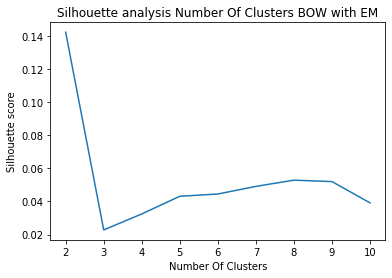

In [332]:
silhouette_avg = []
executer = ThreadPoolExecutor() 
for result  in executer.map(em_train_and_predict_BOW,range(2, 11)):
    silhouette_avg.append(result)
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number Of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis Number Of Clusters BOW with EM')
plt.show()

On Number Of Clusters = 5

In [334]:
gmm = GaussianMixture(n_components=5,random_state=0)
X_BOW = BOW(df,10000)
EM_pred_Bow = gmm.fit_predict(X_BOW)
# to Have good Kappa score
# print(EM_pred_Bow)
replaceNumbersInArray(EM_pred_Bow,[3,2,0,4,1],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(X_BOW, EM_pred_Bow)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,EM_pred_Bow)}')

silhouette_score :0.043158532703480045
cohen_kappa_score: 0.59875


#### Apply K-means for BOW

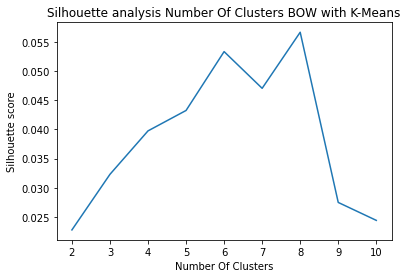

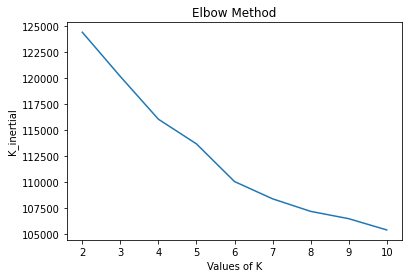

In [335]:
K_inertial = []
silhouette_avg = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10,random_state=0)
    kmeans.fit(X_bag_of_words)
    kmeans_pred_BOW = kmeans.predict(X_bag_of_words)
    K_inertial.append(kmeans.inertia_)
    # silhouette score
    silhouette_avg.append(silhouette_score(X_bag_of_words, kmeans_pred_BOW ))
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number Of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis Number Of Clusters BOW with K-Means')
plt.show()
plt.plot(range(2, 11), K_inertial)
plt.title('Elbow Method')
plt.xlabel('Values of K')
plt.ylabel('K_inertial')
plt.show()


On Number Of Clusters = 5

In [337]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10,random_state=0)
kmeans.fit(X_bag_of_words)
kmeans_pred_BOW = kmeans.predict(X_bag_of_words)
# print(kmeans_pred_BOW)
replaceNumbersInArray(kmeans_pred_BOW,[0,1,4,3,2],[0,1,2,3,4])

print(f'silhouette_score :{silhouette_score(X_bag_of_words, kmeans_pred_BOW)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,kmeans_pred_BOW)}')

silhouette_score :0.0432398669527863
cohen_kappa_score: 0.6775


#### Apply Hierarchical for BOW

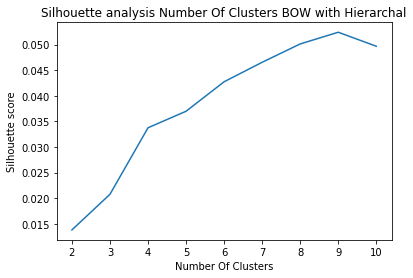

In [338]:
silhouette_avg = []
for i in range(2, 11):

    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    Hirarical_BOW = cluster.fit_predict(X_bag_of_words)
    silhouette_avg.append(silhouette_score(X_bag_of_words, Hirarical_BOW ) )

plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number Of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis Number Of Clusters BOW with Hierarchal')
plt.show()



On Number Of Clusters = 5

In [340]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
Hirarical_BOW = cluster.fit_predict(X_bag_of_words)
# print(Hirarical_BOW)
replaceNumbersInArray(Hirarical_BOW,[0,3,2,1,4],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(X_bag_of_words, Hirarical_BOW)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,Hirarical_BOW)}')

silhouette_score :0.03697880852825128
cohen_kappa_score: 0.67625


## TF-IDF

#### Get TF-IDF Representation

In [341]:
def TF_IDF(df: pd.DataFrame,max_features=None):
    
    count_vect = CountVectorizer() if max_features==None else  CountVectorizer(max_features=500)
    X_counts = count_vect.fit_transform(df['Text'])

    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_counts)
    
    return X_tfidf

X_tfidf= TF_IDF(df)

#### Apply EM for TF-IDF 

In [342]:
#apply EM for tfidf

def em_train_and_predict_tfidf(i):
    gmm = GaussianMixture(n_components=i,random_state=0)
    X_tf = TF_IDF(df,8000)
    EM_pred_tfidf=gmm.fit_predict(X_tf.toarray())
    return silhouette_score(X_tf.toarray(), EM_pred_tfidf )

34.66374545800136


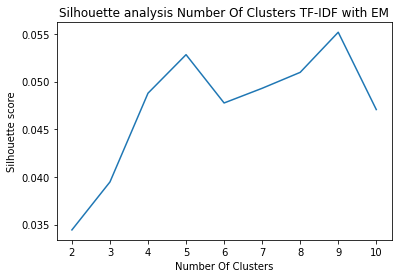

In [343]:
silhouette_avg = []
start = time.perf_counter()
executer = ThreadPoolExecutor() 
for result  in executer.map(em_train_and_predict_tfidf,range(2, 11)):
    silhouette_avg.append(result)
print(time.perf_counter()-start)

plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number Of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis Number Of Clusters TF-IDF with EM')
plt.show()


On Number Of Clusters = 5

In [345]:
gmm = GaussianMixture(n_components=5,random_state=0)
X_tf = TF_IDF(df,8000)
EM_pred_tfidf=gmm.fit_predict(X_tf.toarray())
# print(EM_pred_tfidf)
replaceNumbersInArray(EM_pred_tfidf,[1,3,4,0,2],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(X_tf.toarray(), EM_pred_tfidf)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,EM_pred_tfidf)}')

silhouette_score :0.052816574250746234
cohen_kappa_score: 0.95375


#### Apply K-Means for TF-IDF 

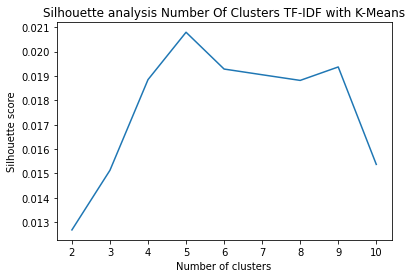

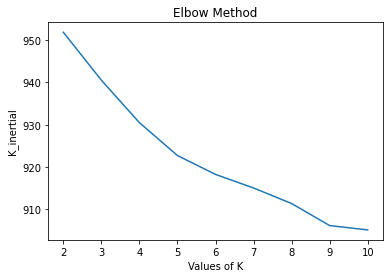

In [346]:
K_inertial = []
silhouette_avg = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10,random_state=0)
    kmeans.fit(X_tfidf)
    kmeans_pred_tfidf = kmeans.predict(X_tfidf)
    K_inertial.append(kmeans.inertia_)
    # print(f'Silhouette Score(K = {i}): {silhouette_score(X_tfidf, kmeans_pred_tfidf )}')
    # silhouette score
    silhouette_avg.append(silhouette_score(X_tfidf, kmeans_pred_tfidf ))
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis Number Of Clusters TF-IDF with K-Means')
plt.show()
plt.plot(range(2, 11), K_inertial)
plt.title('Elbow Method')
plt.xlabel('Values of K')
plt.ylabel('K_inertial')
plt.show()

On Number Of Clusters = 5

In [348]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10,random_state=0)
kmeans.fit(X_tfidf)
kmeans_pred_tfidf = kmeans.predict(X_tfidf)
# print(kmeans_pred_tfidf)
replaceNumbersInArray(kmeans_pred_tfidf,[3,1,0,4,2],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(X_tfidf, kmeans_pred_tfidf)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,kmeans_pred_tfidf)}')

silhouette_score :0.020797152435487958
cohen_kappa_score: 0.96875


#### Apply Hierarchical for TF-IDF 

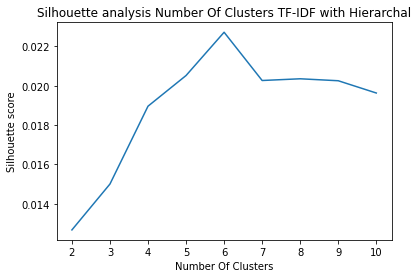

In [349]:
silhouette_avg = []
for i in range(2, 11):

    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    Hirarical_tfidf = cluster.fit_predict(X_tfidf.toarray())
    silhouette_avg.append(silhouette_score(X_tfidf.toarray(), Hirarical_tfidf ) )

plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number Of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis Number Of Clusters TF-IDF with Hierarchal')
plt.show()


On Number Of Clusters = 5

In [351]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
Hirarical_tfidf = cluster.fit_predict(X_tfidf.toarray())
# print(Hirarical_tfidf)
replaceNumbersInArray(Hirarical_tfidf,[4,2,0,1,3],[0,1,2,3,4])

print(f'silhouette_score :{silhouette_score(X_tfidf, Hirarical_tfidf)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,Hirarical_tfidf)}')

silhouette_score :0.020519771864530738
cohen_kappa_score: 0.97125


## Doc2Vec

#### Get Doc2Vec Representation

In [352]:
def get_Vector_from_Doc2Vec(corpus):
    tokenized_df =[]
    for paragraph in corpus:
        tokens = gensim.utils.simple_preprocess(paragraph)
        tokenized_df.append(tokens)
    documents = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_df)]
    doc2vec_model = gensim.models.doc2vec.Doc2Vec(documents,dm=1,vector_size=300, min_count=2, epochs=40, workers =5)
    corpus_vectors=[]
    for line in tokenized_df:
        inferred_vector = doc2vec_model.infer_vector(line)
        corpus_vectors.append(inferred_vector)
    return corpus_vectors

vec = get_Vector_from_Doc2Vec(df['Text'])

#### Apply EM for Doc2Vec 

In [353]:
## EM_with_Doc2Vec
from concurrent.futures import ThreadPoolExecutor
def em_train_and_predict_Doc2Vec(i):
    gmm = GaussianMixture(n_components=i,random_state=0)
    EM_pred_Doc2Vec=gmm.fit_predict(vec)    
    return silhouette_score(vec, EM_pred_Doc2Vec)

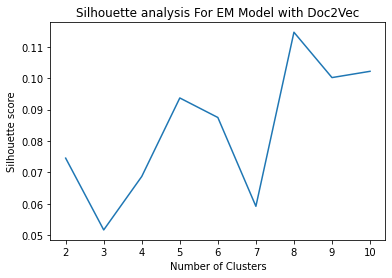

In [354]:
# Word Embedding with EM
silhouette_avg = []
executer = ThreadPoolExecutor() 
for result  in executer.map(em_train_and_predict_Doc2Vec,range(2, 11)):
    silhouette_avg.append(result)
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For EM Model with Doc2Vec')
plt.show()

##### Best K = 5 which is the same as the clusters count so we can calculate kappa score

In [356]:
gmm = GaussianMixture(n_components=5,random_state=0)
EM_pred_Doc2Vec=gmm.fit_predict(vec)    
# to get good kappa score 
replaceNumbersInArray(EM_pred_Doc2Vec,[1,3,4,0,2],[0,1,2,3,4])
# print(EM_pred_Doc2Vec)
print(f'silhouette_score :{silhouette_score(vec, EM_pred_Doc2Vec)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,EM_pred_Doc2Vec)}')

silhouette_score :0.09368185698986053
cohen_kappa_score: 0.625


#### Apply K-Means for Doc2Vec 

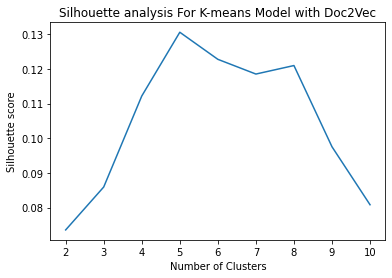

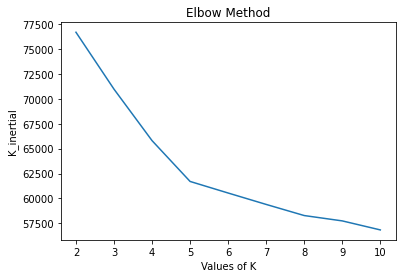

In [357]:
# Word Embedding with K-means
K_inertial = []
silhouette_avg = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10,random_state=0)
    kmeans.fit(vec)
    kmeans_pred_Doc2Vec = kmeans.predict(vec)
    K_inertial.append(kmeans.inertia_)
    # silhouette score
    silhouette_avg.append(silhouette_score(vec, kmeans_pred_Doc2Vec ))
plt.plot(range(2, 11),silhouette_avg)
plt.ylabel('Silhouette score') 
plt.xlabel('Number of Clusters') 
plt.title('Silhouette analysis For K-means Model with Doc2Vec')
plt.show()
plt.plot(range(2, 11), K_inertial)
plt.title('Elbow Method')
plt.xlabel('Values of K') 
plt.ylabel('K_inertial')
plt.show()


In [359]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(vec)
kmeans_pred_Doc2Vec = kmeans.predict(vec)  
# print(kmeans_pred_Doc2Vec)
replaceNumbersInArray(kmeans_pred_Doc2Vec,[0,1,4,3,2],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(vec, kmeans_pred_Doc2Vec)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,kmeans_pred_Doc2Vec)}')

silhouette_score :0.13059763610363007
cohen_kappa_score: 0.98125


#### Apply Hierarchal for Doc2Vec 

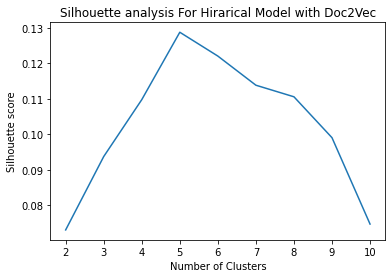

In [360]:
# Word Embedding with Hirarical Model

silhouette_avg = []
for i in range(2, 11):
    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    Hirarical_Doc2Vec= cluster.fit_predict(vec)
    silhouette_avg.append(silhouette_score(vec, Hirarical_Doc2Vec ) )
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Hirarical Model with Doc2Vec')
plt.show()


In [383]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
Hirarical_Doc2Vec_5= cluster.fit_predict(vec)
# print(Hirarical_Doc2Vec_5)
replaceNumbersInArray(Hirarical_Doc2Vec_5,[4,3,0,1,2],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(vec, Hirarical_Doc2Vec_5)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,Hirarical_Doc2Vec_5)}')

silhouette_score :0.12871553003787994
cohen_kappa_score: 0.97875


## LDA

#### Get LDA representation

In [361]:
dictionary = Dictionary([word_tokenize(paragraph) for paragraph in df['Text']])
dictionary.filter_extremes(no_below=20,no_above=50)
corpus = [dictionary.doc2bow(word_tokenize(paragraph)) for paragraph in df['Text']]
ensemble_workers = 4
num_models = 10
distance_workers = 4
num_topics = 100
passes = 2

In [362]:
from gensim.models import EnsembleLda
ensemble = EnsembleLda(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    num_models=num_models,
    topic_model_class=LdaModel,
    ensemble_workers=ensemble_workers,
    distance_workers=distance_workers
)

print(f'topic term distribution: {len(ensemble.ttda)}')
print(len(ensemble.get_topics()))

topic term distribution: 1000
2


In [363]:
from gensim.models.coherencemodel import CoherenceModel

ldaModel = ensemble.generate_gensim_representation()
top_topics = ldaModel.top_topics(corpus)
cm = CoherenceModel(model=ldaModel, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

print(f'Coherance: {coherence}')

Coherance: -1.4638854517249513


#### Apply EM for LDA

In [364]:
## EM_with_Doc2Vec
from concurrent.futures import ThreadPoolExecutor
def em_train_and_predict_lda(i):
    gmm = GaussianMixture(n_components=i,random_state=0)
    EM_pred_lda=gmm.fit_predict(ensemble.ttda)    
    return silhouette_score(ensemble.ttda, EM_pred_lda)

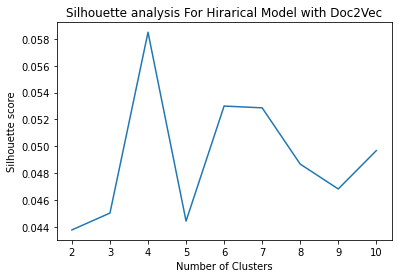

In [365]:
# Word Embedding with EM
silhouette_avg = []
executer = ThreadPoolExecutor() 
for result  in executer.map(em_train_and_predict_lda,range(2, 11)):
    silhouette_avg.append(result)
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Hirarical Model with Doc2Vec')
plt.show()

#### Apply K-Means for LDA

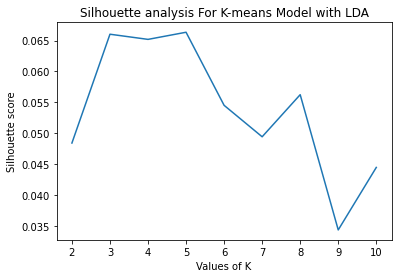

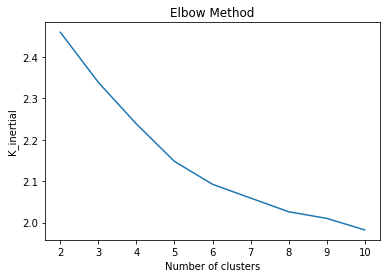

In [366]:
# Word Embedding with K-means
K_inertial = []
silhouette_avg = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10,random_state=0)
    kmeans.fit(ensemble.ttda)
    kmeans_pred_lda = kmeans.predict(ensemble.ttda)
    K_inertial.append(kmeans.inertia_)
    # silhouette score
    silhouette_avg.append(silhouette_score(ensemble.ttda, kmeans_pred_lda ))
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For K-means Model with LDA')
plt.show()
plt.plot(range(2, 11), K_inertial)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('K_inertial')
plt.show()

#### Apply Hierarchical for LDA

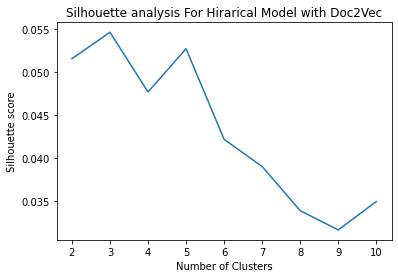

In [367]:
# Word Embedding with Hirarical Model

silhouette_avg = []
for i in range(2, 11):
    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    Hirarical_lda= cluster.fit_predict(ensemble.ttda)
    silhouette_avg.append(silhouette_score(ensemble.ttda, Hirarical_lda ) )
plt.plot(range(2, 11),silhouette_avg)
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Hirarical Model with Doc2Vec')
plt.show()

Champion Model With PCA

In [392]:
from sklearn.decomposition import PCA
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
new_2D_vec = PCA(n_components=2).fit_transform(vec)
Hirarical_Doc2Vec_5= cluster.fit_predict(new_2D_vec)
# print(Hirarical_Doc2Vec_5)
replaceNumbersInArray(Hirarical_Doc2Vec_5,[4,2,0,3,1],[0,1,2,3,4])
print(f'silhouette_score :{silhouette_score(vec, Hirarical_Doc2Vec_5)}')
print(f'cohen_kappa_score: {cohen_kappa_score(y_encoded,Hirarical_Doc2Vec_5)}')

silhouette_score :0.09751569479703903
cohen_kappa_score: 0.8275


silhouette_score as well as kappa_score decreased so we will not use PCA

# Error Analysis

In [370]:
# Create  analysis data frame 
def analysis_data (features_eng_results , data):
  analysis_df = data[['Text', 'label' ]]
  analysis_df['cluster_output'] = pd.DataFrame(features_eng_results.astype(str))
  return analysis_df

In [371]:
# count the number of matches between most frequent words in clusters and true labels
from collections import Counter

def most_frequent_words(num_words ,df_name , label_column , docu_column):
  genres = []
  for label in df_name[label_column].unique():
    genre = df_name[df_name[label_column]==label][docu_column]
    genres.append(genre)

  clusters_label= []
  for cls in range(len(genres)):
    lab = []
    for doc in genres[cls]:
      text = ""
      text += doc
      text += " "
      lab.append(text)
    clusters_label.append(lab)

  clusters_content = []
  for i in range(len(clusters_label)):
    whole_texts = ""
    for j in range(len(clusters_label[i])):
      whole_texts += clusters_label[i][j]
      whole_texts += " "
    clusters_content.append(whole_texts)

  most_frequent_words = []
  most_frequent_words_weights = []

  for ele in range(len(clusters_content)):
    word_list =[]
    weights_list = []
    string = clusters_content[ele]
    split_it = string.split()                # Pass the split_it list to instance of Counter class.
    Count = Counter(split_it)              # most_common() produces k frequently encountered input values and their respective counts.
    most_occur = Count.most_common(num_words)
    for tup in range(len(most_occur)): 
      fw =  most_occur[tup][0]
      weights = most_occur[tup][1]
      word_list.append(fw)
      weights_list.append(weights)

    most_frequent_words.append(word_list)
    most_frequent_words_weights.append(weights_list)

  return most_frequent_words , most_frequent_words_weights

In [372]:
# Create  dictionary of matches 
def matches_dict(labels_mf , clusters_label_mf):
  lab_cls_match = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mf)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      scores_i.append(matches)
    lab_cls_match[i] = scores_i 
  return lab_cls_match

In [373]:
# Create  dictionary of matches_weights
def weights_dict(labels_mf , clusters_label_mf ,clusters_mfw ):
  lab_cls_match_weights = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mfw)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      weight = sum(clusters_mfw[j][0:matches])
      scores_i.append(weight)
    lab_cls_match_weights[i] = scores_i 
  return lab_cls_match_weights

In [374]:
#show list most frequent words and there weights
def most_frequent_words_weights(lbl_list , wgt_list):
  list_most_frequent_words_weights = []
  for i  in range(len(lbl_list)):
    lis = []
    for f, b in zip(lbl_list[i], wgt_list[i]):
      element = [f ,b]
      ele= tuple(element)
      lis.append(ele)
    list_most_frequent_words_weights.append(lis)   
  return list_most_frequent_words_weights

In [384]:
analysis_df = analysis_data(Hirarical_Doc2Vec_5 , df)
analysis_df

,Text,label,cluster_output
0,effectual establishment union best possible pr...,A,0
1,commit interest delicate momentous kind concer...,A,0
2,rung upon wealthy well born great inspire disg...,A,0
3,private justice citizen state supervision agri...,A,0
4,surrendered prince wa magna charta obtained ba...,A,0
...,...,...,...
995,importance diagnosis internal disease wound bo...,E,4
996,burned buried deeply frequently definition let...,E,4
997,severity possible operation one simplicity nev...,E,4
998,rounded elevation size small pea containing bl...,E,4


In [385]:
labels_mf , labels_mfw  = most_frequent_words (10, 
                                               analysis_df,
                                               "label",
                                               "Text")

clusters_mf,clusters_mfw = most_frequent_words( 10,
                                               analysis_df,
                                               "cluster_output",
                                               "Text")

lab_cls_match = matches_dict(labels_mf , clusters_mf)
lab_cls_match

{0: [10, 5, 5, 2, 3],
 1: [2, 2, 4, 10, 0],
 2: [5, 4, 10, 4, 2],
 3: [5, 10, 4, 2, 3],
 4: [3, 3, 2, 0, 10]}

In [386]:
lab_cls_weights = weights_dict(labels_mf ,
                               clusters_mf ,
                               clusters_mfw)
lab_cls_weights

{0: [2678, 1541, 1417, 1176, 1025],
 1: [872, 851, 1165, 2962, 0],
 2: [1785, 1326, 2465, 1779, 804],
 3: [1785, 2504, 1165, 1176, 1025],
 4: [1212, 1094, 634, 0, 2359]}

In [387]:
frequent_elements_labels = most_frequent_words_weights(labels_mf,labels_mfw)
print("\n Frequent words with its occurancies through the aactual class (label) \n")
print("most frequent words in label : 0  \n ", frequent_elements_labels[0] ,"\n")
print("most frequent words in label : 1  \n ", frequent_elements_labels[1] ,"\n")
print("most frequent words in label : 2  \n ", frequent_elements_labels[2] ,"\n")
print("most frequent words in label : 3  \n ", frequent_elements_labels[3] ,"\n")
print("most frequent words in label : 4  \n ", frequent_elements_labels[4] ,"\n")


 Frequent words with its occurancies through the aactual class (label) 

most frequent words in label : 0  
  [('state', 495), ('would', 392), ('government', 341), ('may', 300), ('power', 282), ('ha', 208), ('one', 185), ('people', 181), ('constitution', 180), ('case', 140)] 

most frequent words in label : 1  
  [('wa', 767), ('would', 414), ('king', 313), ('men', 294), ('one', 262), ('u', 244), ('said', 227), ('could', 193), ('sent', 135), ('day', 131)] 

most frequent words in label : 2  
  [('one', 342), ('state', 292), ('ha', 270), ('may', 263), ('said', 252), ('would', 235), ('good', 226), ('wa', 224), ('man', 196), ('like', 161)] 

most frequent words in label : 3  
  [('specie', 605), ('ha', 243), ('one', 242), ('variety', 214), ('case', 211), ('may', 210), ('would', 199), ('form', 199), ('many', 176), ('plant', 170)] 

most frequent words in label : 4  
  [('may', 572), ('animal', 235), ('disease', 221), ('treatment', 221), ('cause', 209), ('horse', 201), ('case', 197), ('sym

In [388]:
frequent_elements_weights = most_frequent_words_weights(clusters_mf,clusters_mfw)
print("\n Frequent words with its occurancies through the aactual cluster (output) \n")
print("most frequent words in cluster : 0  \n ", frequent_elements_weights[0] ,"\n")
print("most frequent words in cluster : 1  \n ", frequent_elements_weights[1] ,"\n")
print("most frequent words in cluster : 2  \n ", frequent_elements_weights[2] ,"\n")
print("most frequent words in cluster : 3  \n ", frequent_elements_weights[3] ,"\n")
print("most frequent words in cluster : 4  \n ", frequent_elements_weights[4] ,"\n")


 Frequent words with its occurancies through the aactual cluster (output) 

most frequent words in cluster : 0  
  [('state', 480), ('would', 392), ('government', 340), ('may', 291), ('power', 282), ('ha', 210), ('one', 185), ('people', 181), ('constitution', 179), ('case', 138)] 

most frequent words in cluster : 1  
  [('specie', 605), ('one', 246), ('ha', 243), ('may', 232), ('variety', 215), ('case', 211), ('form', 203), ('would', 199), ('many', 180), ('plant', 170)] 

most frequent words in cluster : 2  
  [('one', 341), ('state', 293), ('ha', 271), ('may', 260), ('said', 252), ('would', 237), ('good', 227), ('wa', 223), ('man', 196), ('like', 165)] 

most frequent words in cluster : 3  
  [('wa', 764), ('would', 412), ('king', 313), ('men', 290), ('one', 259), ('u', 243), ('said', 226), ('could', 191), ('sent', 134), ('day', 130)] 

most frequent words in cluster : 4  
  [('may', 569), ('animal', 235), ('disease', 221), ('treatment', 221), ('cause', 209), ('horse', 201), ('case'